In [1]:
!echo $PYTHONPATH
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib ipympl

NEURONS_FILE = "basal_ganglia_neurons.yaml"
NETWORK_FILE = "basal_ganglia_network.yaml"
DOPAMINE_FILE = "basal_ganglia_dopamine_susceptibility.yaml"

# FSN [1020] Hz ([55, 62]), D1 and D2 (MSN) [0.5–2.5] Hz ([63]), GPe-TI [40–60] Hz ([45]), GPe-TA [5–15] Hz ([45]) and STN [12–20] Hz ([24]).

/home/dianloo/Desktop/tesi/quilt


## Parameters of the simulation

In [2]:
Tlong = 8000  # ms
dt = 0.1      # ms

points_per_bin = 1/dt     # bins 1 ms wide
sampling_frequency = 1e3  # 1 kHz sampling frequency
burn_in_millis = 600      # the first part of the record to discard (ms)

# Params for trials
n_trials = 10
Tshort = 1500 # ms

## Utils & plots

In [3]:
from scipy.signal import butter, sosfiltfilt, freqz, welch
from scipy.integrate import simpson
from scipy.stats import entropy

def bin_spikes(spikes, points_per_bin = 10):
    binned_signal = np.sum( spikes[:(len(spikes)//points_per_bin)*points_per_bin].reshape(-1, points_per_bin),
                        axis=1).squeeze()
    return binned_signal

def beta_power(sn, population):    
    spikes = sn.populations[population].get_data('spikes')
    binned_spikes = bin_spikes(spikes)[burn_in_millis:]
    T = len(binned_spikes)
    f, PSD = welch(binned_spikes, 
                   sampling_frequency, 
                   nperseg = T/2, # Takes at least 3 windows
                   noverlap= T/4,
                   nfft=None, 
                   scaling='density', 
                   window='hamming')
    print(f"f peak {f[np.argmax(PSD)]}")
    beta_mask = (f>12)&(f<30)
    return np.trapz(PSD[beta_mask], x=f[beta_mask])

def bandpass(data, edges, sample_rate, poles = 5):
    sos = butter(poles, edges, 'bandpass', fs=sample_rate, output='sos')
    filtered_data = sosfiltfilt(sos, data)
    return filtered_data

In [4]:
def plot_spectrum(sn, scale="log"):
    fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
    for ax, pop in zip(axes, sn.populations):
        spikes = sn.populations[pop].get_data('spikes')
        binned_spikes = bin_spikes(spikes)
        binned_spikes = binned_spikes[burn_in_millis:]
        T = len(binned_spikes)
        print(f"Mean firing rate {pop} is {np.sum(spikes)/sn.populations[pop].n_neurons/(Tlong/1000) :.1f} Hz")
        f, PSD = welch(binned_spikes, 
                       sampling_frequency, 
                       nperseg=T/2, 
                       noverlap=T/4,
                       nfft=None, 
                       scaling='density', 
                       window='hamming')
    
        norm = simpson(PSD, x=f)
        ax.plot(f, PSD/norm, label=pop)
        
        ax.set_ylabel(pop)
        ax.set_yscale(scale)
    print(f"F resolution { f[1] - f[0] :.2f} Hz")
    # plt.yscale('log')
    # plt.legend()
    # plt.ylabel("normalized PSD")
    plt.xlabel("Frequency [Hz]")
    plt.xlim(0,150)
    fig.set_figheight(10)
    
def plot_signals(sn):
    fig, axes = plt.subplots(len(sn.populations), 1, sharex=True)
    for ax, pop in zip(axes, sn.populations):
        binned_spikes = bin_spikes(sn.populations[pop].get_data('spikes'))
        instantaneous_fr = binned_spikes/sn.populations[pop].n_neurons*1000
        
        tt = np.linspace(0, len(instantaneous_fr)/1000, len(instantaneous_fr))
        ax.plot(tt, instantaneous_fr)
        ax.plot(tt, bandpass(instantaneous_fr, [12, 24], 1000), label="beta")
        ax.plot(tt, bandpass(instantaneous_fr, [30, 140], 1000), label="gamma")
        ax.set_ylabel(pop)
    # ax.set_xlim(1.5, 2)
    fig.suptitle("Instantaneous firing rate [Hz]")
    ax.set_xlabel("time [s]")
    fig.set_figheight(10)

## Building the network

In [5]:
from quilt.interface.spiking import set_verbosity
set_verbosity(1)

In [19]:
from quilt.builder import NeuronCatalogue, ParametricSpikingNetwork

neuron_catalogue = NeuronCatalogue.from_yaml(NEURONS_FILE)
sn = ParametricSpikingNetwork.from_yaml(NETWORK_FILE, 
                                        DOPAMINE_FILE, 
                                        neuron_catalogue)


In [7]:
# from quilt.view import plot_graph
# fig, ax = plt.subplots()
# plot_graph(sn)
# plt.show()

## Monitors

In [20]:
sn.monitorize_spikes()

## Control case (Healthy subject)

In [9]:
sn.set_parameters(dopamine=1.0)
sn.run(dt=dt, time=Tlong)

Building parametric network with params {'dopamine': 1.0}

Output()

Running network consisting of 14622 neurons for 80000 timesteps
--------------------------------------------------
**************************************************
Simulation took 153 s	(1.917 ms/step)
	Gathering time avg: 0.0701125 us/step
	Inject time avg: 208.734 us/step
Population evolution stats:
	0:
		evolution:	529.18 us/step	---	88 ns/step/neuron
		spike emission:	48.982 us/step	---	8 ns/step/neuron
	1:
		evolution:	504.422 us/step	---	84 ns/step/neuron
		spike emission:	74.6281 us/step	---	12 ns/step/neuron
	2:
		evolution:	95.7015 us/step	---	227 ns/step/neuron
		spike emission:	13.1071 us/step	---	31 ns/step/neuron
	3:
		evolution:	124.153 us/step	---	159 ns/step/neuron
		spike emission:	22.6332 us/step	---	29 ns/step/neuron
	4:
		evolution:	67.8677 us/step	---	261 ns/step/neuron
		spike emission:	6.54775 us/step	---	25 ns/step/neuron
	5:
		evolution:	79.7959 us/step	---	195 ns/step/neuron
		spike emission:	5.42469 us/step	---	13 ns/step/neuron
	6:
		evolution:	122.277 us/

In [10]:
spikes = dict()
for pop in sn.populations.keys():
    spikes[pop] = sn.populations[pop].get_data('spikes')

Mean firing rate D1 is 0.7 Hz
Mean firing rate D2 is 1.5 Hz
Mean firing rate FSN is 16.5 Hz
Mean firing rate GPeTI is 65.4 Hz
Mean firing rate GPeTA is 9.9 Hz
Mean firing rate STN is 13.4 Hz
Mean firing rate SNR is 13.2 Hz
F resolution 0.27 Hz


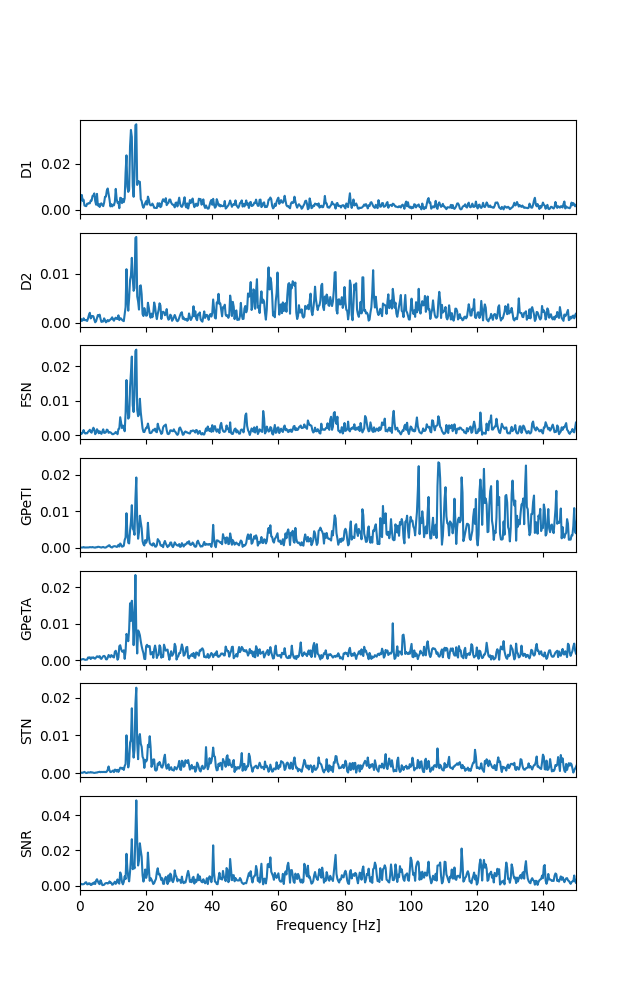

In [11]:
# print(beta_power(sn, "GPeTA"))
plot_spectrum(sn, scale="linear")

(1.5, 2.0)

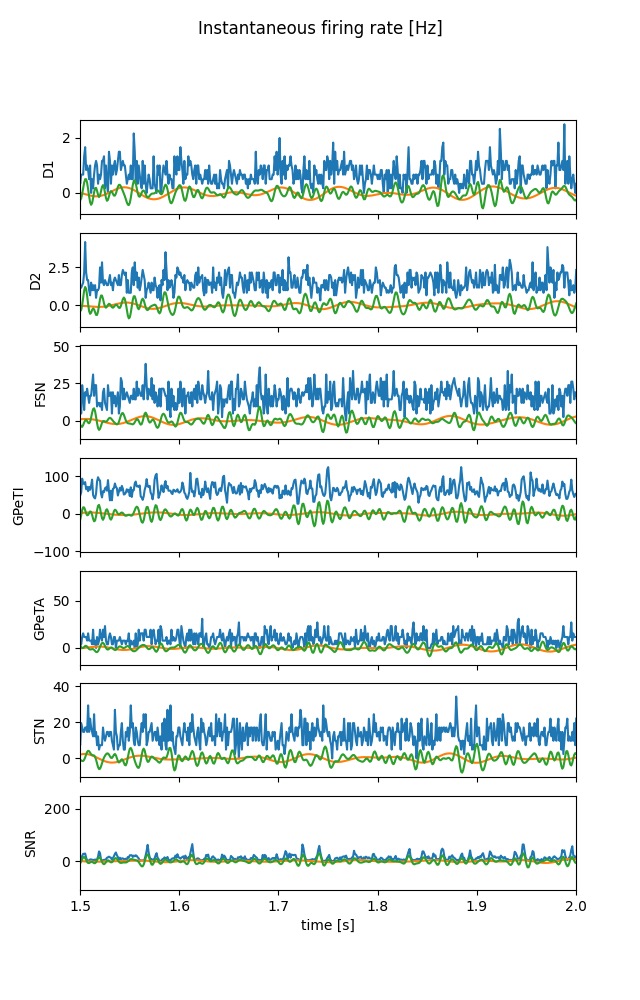

In [12]:
plot_signals(sn)
plt.gca().set_xlim(1.5, 2)

## Lesioned case (PD)

In [21]:
sn.set_parameters(dopamine=0.65)
sn.run(dt=dt, time=Tlong)

Building parametric network with params {'dopamine': 0.65}

Mean firing rate D1 is 1.6 Hz
Mean firing rate D2 is 1.5 Hz
Mean firing rate FSN is 14.9 Hz
Mean firing rate GPeTI is 57.2 Hz
Mean firing rate GPeTA is 4.9 Hz
Mean firing rate STN is 14.6 Hz
Mean firing rate SNR is 40.6 Hz
F resolution 0.27 Hz


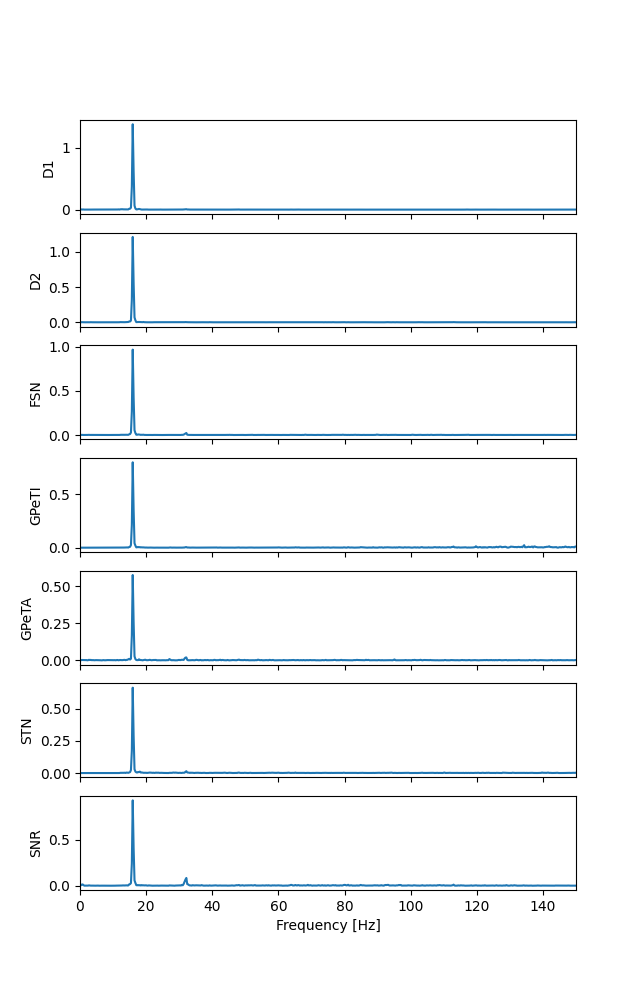

In [22]:
plot_spectrum(sn, scale="linear")

(1.5, 2.0)

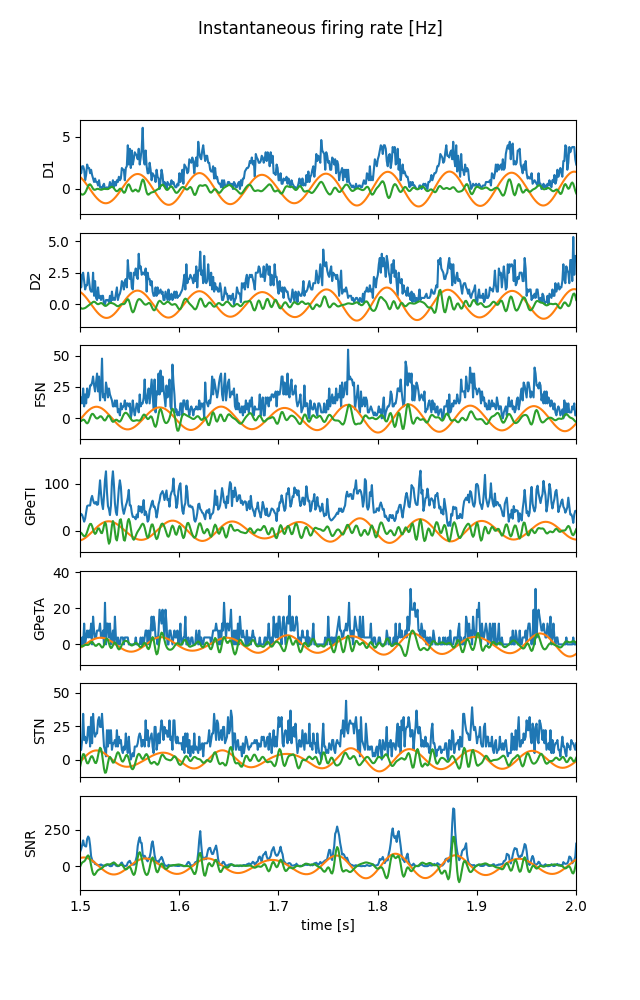

In [23]:
plot_signals(sn)
plt.gca().set_xlim(1.5, 2)

## Tuning
Starts an optuna study to tune `poisson_rescale` and `weight_rescale`. As objective function the total beta-range power is chosen.

In [16]:
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

In [17]:
def build_network(poisson_rescale, rescale_weights):
    global neuron_catalogue
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

    # sn.rescale_populations(0.2)
    # sn.rescale_connectivity(1)
    sn.rescale_weights(rescale_weights)
    # sn.rescale_delays(1)
    
    sn.build()

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [6000, 0.55],
                          D1    = [1120, 0.45],
                          D2    = [972.972, 0.45]
                        )
    # poisson_rescale = 0.8
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    
    return sn
    
def optimize_beta_power(trial):
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
                       trial.suggest_float("weight_rescale", 0.1, 2))
    sn.run(dt=0.1, time=Tshort)
    return beta_power(sn, "GPeTA")

In [18]:
set_verbosity(0) # Turns off C++ outputs

study_power = optuna.create_study(direction = 'maximize')
study_power.optimize(optimize_beta_power, n_trials = n_trials, n_jobs = 3, catch=(ValueError, TypeError))

[I 2024-02-03 14:23:26,187] A new study created in memory with name: no-name-d5b02b2f-29ac-4bfa-834c-6d62e9c09a96
[W 2024-02-03 14:23:26,189] Trial 0 failed with parameters: {'poisson_rescale': 0.9436155947643358, 'weight_rescale': 0.7438701953690859} because of the following error: NameError("name 'SpikingNetwork' is not defined").
Traceback (most recent call last):
  File "/home/dianloo/Desktop/tesi/quilt/venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1401501/3057679120.py", line 33, in optimize_beta_power
    sn = build_network(trial.suggest_float("poisson_rescale", 0.1 , 2 ),
  File "/tmp/ipykernel_1401501/3057679120.py", line 3, in build_network
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)
NameError: name 'SpikingNetwork' is not defined
[W 2024-02-03 14:23:26,221] Trial 1 failed with parameters: {'poisson_rescale': 1.363293410846613, 'weight_rescale': 1.893575745500

NameError: name 'SpikingNetwork' is not defined

In [ ]:
x = []
y = []
z = []
for trial in study_power.trials:
    x += [trial.params['poisson_rescale']]
    y += [trial.params['weight_rescale']]
    z += [trial.value]

fig, ax = plt.subplots()
plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_power.best_params['poisson_rescale'],study_power.best_params['weight_rescale'], marker="x", color="r")
plt.xlabel("Poisson weight global factor [a.u.]")
plt.ylabel("Internal weight global factor [a.u.]")
plt.title("Integrated beta power")

plt.show()

## Plot best params

In [ ]:
set_verbosity(1)
best_params = study_power.best_params

print(best_params)
print(study_power.best_value)

sn = build_network(best_params['poisson_rescale'], best_params['weight_rescale'])
sn.run(dt=dt, time=Tlong)

In [ ]:
plot_spectrum(sn, scale="log")

## Time signal analysis

In [ ]:
plot_signals(sn)

## Spectral entropy

In [ ]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972):
    global neuron_catalogue    
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [6000, 0.55],
                          D1    = [D1_freq, 0.45],
                          D2    = [D2_freq, 0.45]
                        )

    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def optimize_spectral_entropy(trial):
    sn = build_network(trial.suggest_float("D1_freq", 800, 1200),
                       trial.suggest_float("D2_freq", 800, 1200)
                      )    
    sn.run(dt=0.1, time=Tshort)
    return spectral_entropy(sn, "D1")

In [ ]:
set_verbosity(0) 

study_entropy = optuna.create_study(direction = 'minimize')
study_entropy.optimize(optimize_spectral_entropy, n_trials = 30, n_jobs = 3, catch=(ValueError, TypeError))

In [ ]:
x = []
y = []
z = []
for trial in study_entropy.trials:
    x += [trial.params['D1_freq']]
    y += [trial.params['D2_freq']]
    z += [trial.value]

fig, ax = plt.subplots()

plt.scatter(x, y, c=z)
plt.colorbar()
plt.scatter(study_entropy.best_params['D1_freq'],study_entropy.best_params['D2_freq'], marker="x", color="r")

plt.xlabel("D1 poisson rate [Hz]")
plt.ylabel("D2 poisson rate [Hz]")
plt.title("Spectral entropy of D1")
plt.show()

In [ ]:
set_verbosity(1)
best_params = study_entropy.best_params

print(best_params)
print(study_entropy.best_value)

sn = build_network(**best_params)
# sn = build_network(D1_freq=best_params['D1_freq'], D2_freq=best_params['D2_freq'])
sn.run(dt=dt, time=Tlong)

In [ ]:
plot_spectrum(sn)

In [ ]:
plot_signals(sn)

## More parameters

In [ ]:
from scipy.stats import entropy

def build_network(D1_freq = 1120, D2_freq = 972.972, D1_weight=0.45, D2_weight=0.45, 
                    FSNtoD1_w=6.6, FSNtoD2_w=4.8, 
                    weight_delta=0, delay_delta=0.0, run_time=Tshort):
    
    global neuron_catalogue
    sn = SpikingNetwork.from_yaml(NETWORK_FILE, neuron_catalogue)

    # sn.rescale_populations(0.1)
    # sn.rescale_connectivity(1)
    sn.rescale_weights(1.17)
    # sn.rescale_delays(1)
    for projection in sn.features_dict['projections']:
        projection['features']['weight_delta'] = weight_delta
        # projection['features']['delay_delta'] = delay_delta
        if projection['name'] == "FSN->D1":
            projection['features']['weight'] = FSNtoD1_w
        if projection['name'] == "FSN->D2":
            projection['features']['weight'] = FSNtoD2_w
        
    sn.build(progress_bar=False)

    for pop in sn.populations.values():
       pop.monitorize_spikes()

    poisson_inputs = dict(STN   = [500, 0.25],
                          GPeTA = [170, 0.15],
                          GPeTI = [1530, 0.25 ],
                          FSN   = [944.4, 0.5],
                          SNR   = [6000, 0.55],
                          D1    = [D1_freq, D1_weight],
                          D2    = [D2_freq, D2_weight]
                        )
    
    poisson_rescale = 1.85
    for pi in poisson_inputs.values():
        pi[1] *= poisson_rescale
        
    for pop in poisson_inputs:
        sn.populations[pop].add_poisson_spike_injector(*poisson_inputs[pop])
    return sn

def optimize_spectral_entropy_2(trial):

    params_intervals = dict(D1_freq = [1000,1300], D2_freq = [800, 1100], D1_weight=[0.35, 0.55], D2_weight=[0.35, 0.55], 
                    FSNtoD1_w=[5.6, 7.6], FSNtoD2_w=[3.8, 5.8], 
                    weight_delta=[0, 1], delay_delta=[0,0.5])
    
    params_suggestions = dict()
    for param_name in params_intervals.keys():
        params_suggestions[param_name] = trial.suggest_float(param_name, *(params_intervals[param_name]))
    # params_default = dict(D1_freq = 1120, D2_freq = 972.972, D1_weight=0.45, D2_weight=0.45, 
    #                 FSNtoD1_w=6.6, FSNtoD2_w=4.8, 
    #                 weight_delta=0, delay_delta=0.0)
    sn = build_network(**params_suggestions)
    time = trial.suggest_int(run_time, Tshort/3, Tshort)
    sn.run(dt=0.1, time=Tshort)
    return spectral_entropy(sn, "D1")

In [ ]:
set_verbosity(0) 

study_entropy2 = optuna.create_study(direction = 'minimize', study_name="entropy2")
study_entropy2.optimize(optimize_spectral_entropy_2, n_trials = n_trials, n_jobs = 3, catch=(RuntimeError))

In [ ]:
results_df = study_entropy2.trials_dataframe()
results_df.to_csv('entropy2_eeee.csv', index=False)

In [ ]:
set_verbosity(1)
best_params = study_entropy2.best_params

print(best_params)
print(study_entropy2.best_value)
sn = build_network(**best_params)

sn.run(dt=dt, time=Tlong)

In [ ]:
plot_spectrum(sn)
plot_signals(sn)